We setup the tensorflow library to utilized the computers GPU below:

In [1]:
# Import package needed
import numpy as np # had to revert back to v1.23 in conda env
import pandas as pd

In [2]:
# Brings in tensorflow
import tensorflow as tf

In [3]:
# Checks that GPU avaliable
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow as tf

# List all available devices recognized by TensorFlow
print("Available devices:", tf.config.list_physical_devices())

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Specifically check for GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU is available.")


1 Physical GPUs, 1 Logical GPUs


Here, we bring in the pytorch libraries we have been working on in class.

In [6]:
import sys
import sklearn
import os
import numpy as np
from functools import partial
import PIL
from PIL import Image

import torch
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torch.nn as nn
import copy

from torch import manual_seed as torch_manual_seed
import random

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from torch import Generator
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image

In [7]:
import torch

print(torch.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("Available GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CUDA is not available.")

2.4.0.dev20240406
Is CUDA available: True
Available GPUs: 1
GPU Name: NVIDIA GeForce RTX 4090


In [8]:
print(torch.__version__)

2.4.0.dev20240406


In [9]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [10]:
from sklearn.datasets import load_files

# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 256
img_width = 256

In [11]:
# Sets path to project directory where the folder with data is contained
dataset_path = "C:/Users/affes/OneDrive/Documents/UVA SDS Spring 2024/DS 6050/Final Project/"
images_dir = os.path.join(dataset_path, 'origin/')  
labels_file = os.path.join(dataset_path, 'label.lst')

In [12]:
'''
class FaceData(Dataset):
    def __init__(self, images_dir, labels_file, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.samples = self._load_samples(labels_file)

    def _load_samples(self, labels_file):
        samples = []
        with open(labels_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                image_name, expression_label = parts[0], int(parts[-1])
                samples.append((image_name, expression_label))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_name, label = self.samples[idx]
        img_path = os.path.join(self.images_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
'''

"\nclass FaceData(Dataset):\n    def __init__(self, images_dir, labels_file, transform=None):\n        self.images_dir = images_dir\n        self.transform = transform\n        self.samples = self._load_samples(labels_file)\n\n    def _load_samples(self, labels_file):\n        samples = []\n        with open(labels_file, 'r') as f:\n            for line in f:\n                parts = line.strip().split()\n                image_name, expression_label = parts[0], int(parts[-1])\n                samples.append((image_name, expression_label))\n        return samples\n\n    def __len__(self):\n        return len(self.samples)\n\n    def __getitem__(self, idx):\n        image_name, label = self.samples[idx]\n        img_path = os.path.join(self.images_dir, image_name)\n        image = Image.open(img_path).convert('RGB')\n        if self.transform:\n            image = self.transform(image)\n        return image, label\n"

In [13]:
class FaceData(Dataset):
    def __init__(self, images_dir, labels_file, transform=None, subset_size=None):
        self.images_dir = images_dir
        self.transform = transform
        self.samples = self._load_samples(labels_file)
        if subset_size:
            self.samples = self._create_balanced_subset(subset_size)

    def _load_samples(self, labels_file):
        samples = []
        with open(labels_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                image_name, expression_label = parts[0], int(parts[-1])
                samples.append((image_name, expression_label))
        return samples

    def _create_balanced_subset(self, subset_size):
        # Group samples by label
        grouped_samples = {}
        for image_name, expression_label in self.samples:
            if expression_label not in grouped_samples:
                grouped_samples[expression_label] = []
            grouped_samples[expression_label].append((image_name, expression_label))
        
        # Determine number of samples per label for balanced distribution
        samples_per_label = subset_size // len(grouped_samples)
        
        # Randomly select samples from each group
        balanced_subset = []
        for label_samples in grouped_samples.values():
            if len(label_samples) > samples_per_label:
                balanced_subset.extend(random.sample(label_samples, samples_per_label))
            else:  # If not enough samples for the label, take all available
                balanced_subset.extend(label_samples)
        
        return balanced_subset

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_name, label = self.samples[idx]
        img_path = os.path.join(self.images_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [14]:
# Define your transformations (preprocessing data)
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Resize the image to 256x256 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Normalize images (values are standard for VGG)
])

faces_dataset = FaceData(images_dir=images_dir, labels_file=labels_file, transform=transform, subset_size = 5000)

In [15]:
TEST_RATIO = 0.2
VALIDATION_RATIO = 0.2

size_all = len(faces_dataset)
print(f'Before splitting the full dataset into train and test: len(dataset_all)={size_all}')

size_test = int(size_all * TEST_RATIO)
size_train_val = size_all - size_test
size_train = int((1 - VALIDATION_RATIO) * size_train_val)
size_val = size_train_val - size_train

dataset_train_val, dataset_test = random_split(faces_dataset, [size_train_val, size_test], generator=Generator().manual_seed(SEED))

# NOTE that you must not use the test dataset for model selection
# Split into train and validation
dataset_train, dataset_val = random_split(dataset_train_val, [size_train, size_val], generator=Generator().manual_seed(SEED))

print(f'After splitting the full dataset into train and test: len(dataset_train)={len(dataset_train)}; len(dataset_val)={len(dataset_val)}; len(dataset_test)={len(dataset_test)}')

Before splitting the full dataset into train and test: len(dataset_all)=4998
After splitting the full dataset into train and test: len(dataset_train)=3199; len(dataset_val)=800; len(dataset_test)=999


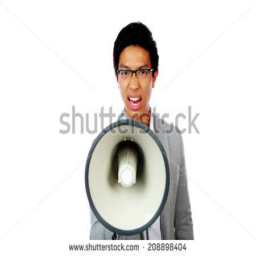

In [16]:
to_pil_image(faces_dataset[2][0])

In [17]:
from time import perf_counter

# Tweaked to add Gradient Accumulation; allows larger batch size without running out of memory
def train_loop(dataloader, model, loss_fn, optimizer, accumulation_steps=4):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Calculate when to give update
    update_interval = num_batches // 5
    
    accumulated_loss = 0.0
    optimizer.zero_grad()  # Initialize gradient accumulation
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y) / accumulation_steps  # Scale loss

        # Backward pass with accumulation
        loss.backward()
        accumulated_loss += loss.item()

        # Perform optimization step every 'accumulation_steps' batches
        if (batch + 1) % accumulation_steps == 0 or (batch + 1) == len(dataloader):
            optimizer.step()
            optimizer.zero_grad()  # Clear gradients for the next set of accumulation steps

        # Adjust the condition to print based on the actual number of updates
        if (batch + 1) // accumulation_steps % update_interval == 0:
            # Correct accumulated_loss for reporting
            corrected_loss = accumulated_loss * accumulation_steps
            # Calculate the accurate 'current' progress
            current = (batch + 1) * len(X) if (batch + 1) < len(dataloader) else size
            print(f"loss: {corrected_loss:>7f}  [{current:>5d}/{size:>5d}]")
            accumulated_loss = 0.0  # Reset accumulated loss for next reporting period
            # Print GPU memory usage
            print(f"Current GPU Memory Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB | Max GPU Memory Allocated: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB | GPU Memory Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

    return corrected_loss

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return correct

In [18]:
# Load necessary packages
from torch.nn import Module
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=150, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=150, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=150, shuffle=True)
dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train':len(dataset_train), 'val':len(dataset_val)}

In [19]:
# Create first model as VGG model that is pretrained
class Feelings_Model(Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load the pretrained VGG model
        from torchvision import datasets, models, transforms
        self.vgg = models.vgg13_bn(weights='DEFAULT')

        self.features = self.vgg.features
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5),
            torch.nn.Conv2d(512, num_classes, kernel_size=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveAvgPool2d((1, 1))
        )

        # Replace the classifier in the VGG model
        self.vgg.classifier = self.classifier

    def forward(self, X):
        # Forward pass through the modified VGG
        features = self.features(X)
        output = self.vgg.classifier(features)
        return output.squeeze()

In [20]:
# Create instance of pretrained vgg model
FM_Vgg = Feelings_Model(num_classes=7)

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FM_Vgg.to(device)

Feelings_Model(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
optimizer_ft = optim.SGD(FM_Vgg.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
epochs = 10
num_steps = 3

train_losses = []
val_losses = []

start = perf_counter() # Total time counter

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    FM_Vgg.train()
    train_loss = train_loop(dataloader = train_dataloader, model = FM_Vgg, loss_fn = loss_fn, optimizer = optimizer_ft, accumulation_steps=num_steps)
    stop = perf_counter() # Finish Counter
    # Calculates current time since start
    print(f"Total run time: {(stop - start)/60:0.4f} m.")
    FM_Vgg.eval()
    val_loss = test_loop(val_dataloader, FM_Vgg, loss_fn)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch 1
-------------------------------
loss: 1.957878  [  150/ 3199]
Current GPU Memory Allocated: 0.18 GB | Max GPU Memory Allocated: 34.27 GB | GPU Memory Cached: 34.27 GB
loss: 1.943664  [  300/ 3199]
Current GPU Memory Allocated: 0.18 GB | Max GPU Memory Allocated: 34.27 GB | GPU Memory Cached: 34.27 GB
loss: 19.478700  [ 1800/ 3199]
Current GPU Memory Allocated: 0.18 GB | Max GPU Memory Allocated: 34.27 GB | GPU Memory Cached: 34.27 GB
loss: 1.949336  [ 1950/ 3199]
Current GPU Memory Allocated: 0.22 GB | Max GPU Memory Allocated: 34.27 GB | GPU Memory Cached: 34.27 GB
loss: 1.950971  [ 2100/ 3199]
Current GPU Memory Allocated: 0.22 GB | Max GPU Memory Allocated: 34.27 GB | GPU Memory Cached: 34.27 GB
Total run time: 4.4123 m.
Test Error: 
 Accuracy: 16.5%, Avg loss: 1.945040 

Epoch 2
-------------------------------
loss: 1.939079  [  150/ 3199]
Current GPU Memory Allocated: 0.22 GB | Max GPU Memory Allocated: 34.27 GB | GPU Memory Cached: 34.27 GB
loss: 1.952131  [  300/ 3199]
C